Referencia: 
https://www.kaggle.com/yekenot/pooled-gru-fasttext

In [ ]:
!git clone https://github.com/godinezseba/Tarea-2-RedesNeuronales

Cloning into 'Tarea-2-RedesNeuronales'...
remote: Enumerating objects: 2152, done.
remote: Counting objects: 100% (2152/2152), done.
remote: Compressing objects: 100% (2152/2152), done.
remote: Total 35840 (delta 1), reused 2148 (delta 0), pack-reused 33688
Receiving objects: 100% (35840/35840), 797.68 MiB | 37.59 MiB/s, done.
Resolving deltas: 100% (325/325), done.
Checking out files: 100% (36724/36724), done.


In [ ]:
!pip install tweet-preprocessor
%pip install scanf==1.5.2
%pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 4.5MB/s 
     |████████████████████████████████| 235kB 18.7MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.metrics import  classification_report
import tensorflow as tf
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Cargar datos

In [ ]:
train = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

In [ ]:
labels = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_labels.csv' )

In [ ]:
test = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/test_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

In [ ]:
labels['label'].value_counts()

non-rumor     524
false         520
true          514
unverified    368
Name: label, dtype: int64

In [ ]:
train['Tweet'] = train['Tweet'].apply(lambda x: x.lower())
train['Tweet'] = train['Tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test['Tweet'] = test['Tweet'].apply(lambda x: x.lower())
test['Tweet'] = test['Tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

#Limpiar datos

In [ ]:
#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [ ]:
# clean training data
train_tweet = clean_tweets(train["Tweet"])
train_tweet = pd.DataFrame(train_tweet)
# append cleaned tweets to the training data
train["clean_tweet"] = train_tweet

In [ ]:
# compare the cleaned and uncleaned tweets
train.head(10)

,ID,Tweet,clean_tweet
0,692735698349199360,north korea planning some kind of rocket launc...,north korea planning some kind of rocket launc...
1,525008463819464704,meet kevin vickers the hero who shot down the ...,meet kevin vickers the hero who shot down the ...
2,505611045897924608,15 year old who swatted gamer convicted of dom...,year old who swatted gamer convicted of domest...
3,693466724822323200,audio recordings reveal cpr started 11 minutes...,audio recordings reveal cpr started minutes af...
4,510922415468449792,awful mt scclemonsuk aid worker david haines b...,awful mt scclemonsuk aid worker david haines b...
5,549975297160802304,dammit a transgender 17yearold left a suicide...,dammit a transgender yearold left a suicide no...
6,500378522788315137,ferguson police officer involved in fatal shoo...,ferguson police officer involved in fatal shoo...
7,528607634099015680,animaloftheday the first afghan fanged deer wa...,animaloftheday the first afghan fanged deer wa...
8,489854703321509888,nine britons 23 us citizens and 80 children fe...,nine britons us citizens and children feared d...
9,521444489697583104,photos proved that terrorists used chemical we...,photos proved that terrorists used chemical we...


In [ ]:

# clean the test data and append the cleaned tweets to the test data
test_tweet = clean_tweets(test["Tweet"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["clean_tweet"] = test_tweet

# compare the cleaned and uncleaned tweets
test.tail()

,ID,Tweet,clean_tweet
208,642432477185867776,the stickers on fruit are edible,the stickers on fruit are edible
209,693236688538243074,is the truth out there in nod to thexfiles cia...,is the truth out there in nod to thexfiles cia...
210,504131150429061121,breaking fbi uncovers new audio from neighbor ...,breaking fbi uncovers new audio from neighbor ...
211,692004901455556608,potus just announced new reforms to address th...,potus just announced new reforms to address th...
212,692157602554343424,waiting for the new episode of teenwolf like url,waiting for the new episode of teenwolf like url


#Word Embedding

In [ ]:
embed_dim = 300

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

import string
from nltk.tokenize import word_tokenize



review_lines = list()
lines = train["clean_tweet"].values.tolist()

for line in lines:
  tokens = word_tokenize(line)
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens] 
  words = [word for word in stripped if word.isalpha()]
  review_lines.append(words)
  
len(review_lines)


1926

In [ ]:
import gensim

model = gensim.models.Word2Vec(sentences = review_lines, size = embed_dim, 
                               window = 5, workers = 4, min_count = 0)
words = list(model.wv.vocab)
print('Tamaño vocabulario', len(words))

Tamaño vocabulario 5606


In [ ]:
word_ids = model.wv.index2word  # list of node IDs
word_embeddings = (model.wv.vectors)
#print(word_embeddings[0])
print(len(word_ids))

5606


In [ ]:
embedding_matrix = np.zeros((len(word_ids),embed_dim))


for i in range(embedding_matrix.shape[0]-1):

  embedding_matrix[i] =word_embeddings[i]


#node2Vec

In [ ]:
import os.path
from scanf import scanf
from gensim.models import Word2Vec
import networkx as nx
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

import matplotlib.pyplot as plt

In [ ]:
def createGraph(DIR, fileGraph, labels):
  if(not os.path.exists(fileGraph)): # para ejecutar existiendo el archivo basta con quital el 'not'
    format = "['%s', '%s', '%f']->['%s', '%s', '%f']"
    # edges
    source = list()
    target = list()
    # nodes
    index = list()
    time = list()

    bigGraph = nx.Graph()

    list_len_edges = list()

    for file in labels:
      fileName = f'{DIR}/{file}.txt'
      count_edges = 0
      with open(fileName, 'r') as f:
        for line in f:
          parentId, parentTweet, parentTime, childId, childTweet, childTime = scanf(format, line.strip())
          if(parentId != 'ROOT'):
            # add edge to the big Graph
            bigGraph.add_edge(parentTweet, childTweet)
            count_edges += 1
            bigGraph.add_node(parentTweet, time=[parentTime])
            bigGraph.add_node(childTweet, time=[childTime])
      list_len_edges.append(count_edges)

    nx.write_gpickle(bigGraph, fileGraph)
  else:
    list_len_edges = list()
    bigGraph = nx.read_gpickle(fileGraph)
  return bigGraph, list_len_edges

In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/train'
fileGraph = './drive/My Drive/Tarea 2 - Kaggle/graph.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, labels['id'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 67723
Number of edges: 71020
Average degree:   2.0974
StellarGraph: Undirected multigraph
 Nodes: 67723, Edges: 71020

 Node types:
  default: [67723]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [71020]
        Weights: all 1 (default)
        Features: none


In [ ]:
vectorDimension = 256
def graphEmbedding(graph, file, labels):
  if(not os.path.exists(file)): # para ejecutar existiendo el archivo basta con quital el 'not'
    rw = BiasedRandomWalk(graph)

    root_nodes = [str(n) for n in labels]

    walks = rw.run(
        nodes=root_nodes,  # root nodes
        length=200,  # maximum length of a random walk
        n=100,  # number of random walks per root node
        p=0.5,
        q=2.0
    )
    print("Number of random walks: {}".format(len(walks)))

    str_walks = [[str(n) for n in walk] for walk in walks]
    embedding = Word2Vec(str_walks, 
                        size=vectorDimension, 
                        window=5, 
                        min_count=0, 
                        sg=1, 
                        workers=4, 
                        iter=1)
    embedding.save(file)
  else:
    embedding = Word2Vec.load(file)
  return embedding

In [ ]:
#file_train = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/node.word2vec'
file_train = './drive/My Drive/Tarea 2 - Kaggle/node.word2vec'

embedding = graphEmbedding(graph, file_train, labels['id'])

embeddings = np.array([embedding.wv[str(x)] for x in labels['id']])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#LTSM+ graph

In [ ]:
le = LabelEncoder()

qwer = le.fit_transform(labels['label'])

In [ ]:
X_train = train["clean_tweet"].values
y_train = pd.get_dummies(labels['label']).values
X_test = test["clean_tweet"].values

In [ ]:
max_features = 30000
maxlen = 100
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [ ]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True
)
def get_model():
    input_graph = Input(shape=(vectorDimension, ), name="graph")
    inp = Input(shape=(maxlen, ), name="text")
    x = Embedding(5606, embed_size, weights=[embedding_matrix])(inp)
    #x = Embedding(max_features, embed_size)(inp)
    #x = SpatialDropout1D(0.25)(x)
    x = Bidirectional(LSTM(60, dropout=0.5, recurrent_dropout=0.5))(x)
  
    #x = Bidirectional(GRU(50,dropout=0.5, recurrent_dropout=0.5, return_sequences=True))(x)
    #avg_pool = GlobalAveragePooling1D()(x)
    #max_pool = GlobalMaxPooling1D()(x)
    #conc = concatenate([avg_pool, max_pool, input_graph])
    
    conc = concatenate([x,input_graph ])
    dense = Dense(100, activation="relu")(conc)
    dense= Dropout(0.2)(dense)
    outp = Dense(4, activation="softmax")(dense)
    
    model = Model(inputs=[inp, input_graph], outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
model = get_model()

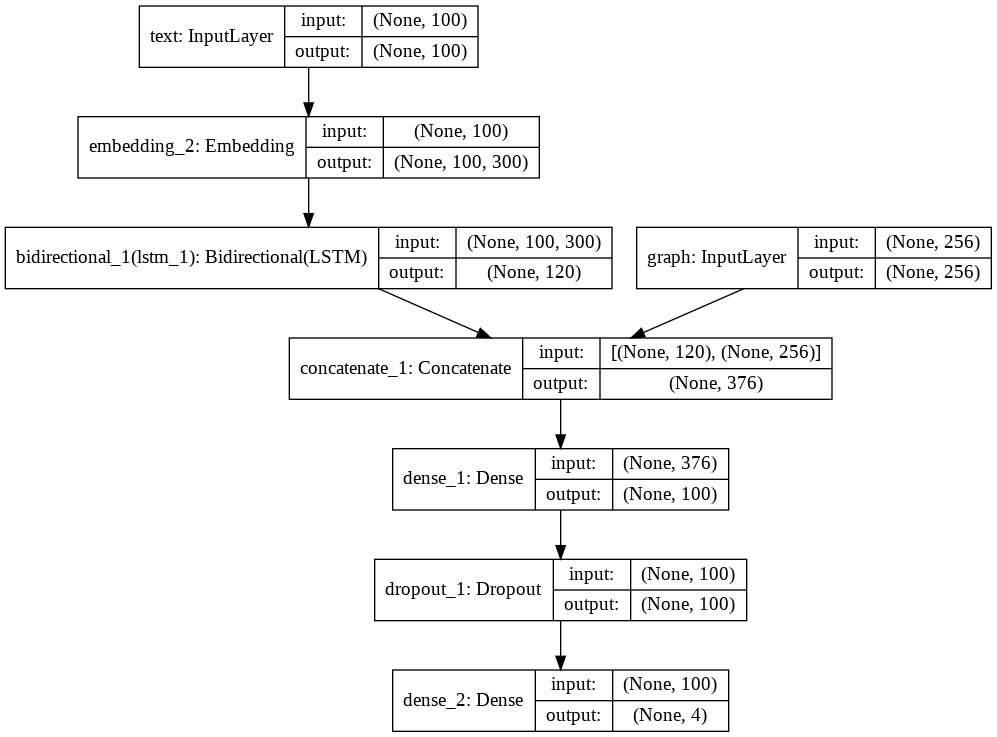

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
mask_test = np.random.rand(x_train.shape[0]) < 0.2
X_tra = x_train[~mask_test]
X_val = x_train[mask_test]

X_train_graph = embeddings[~mask_test]
X_val_graph = embeddings[mask_test]

y_tra = y_train[~mask_test]
y_val = y_train[mask_test]

In [ ]:
#y_train2 = labels['label'].values
#y_train2 = y_train2[mask_test]

In [ ]:
batch_size = 32
epochs = 200

#X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)


#hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks=[es], verbose=2)
hist = model.fit({"text": X_tra, "graph": X_train_graph}, 
                 y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=({"text": X_val, "graph": X_val_graph}, y_val),
                 callbacks=[es], 
                 verbose=2
                 #,class_weight = {0:0.7,1:0.8,2:1,3:4} 
                 )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1542 samples, validate on 384 samples
Epoch 1/200
 - 19s - loss: 0.5744 - accuracy: 0.7489 - val_loss: 0.5672 - val_accuracy: 0.7507
Epoch 2/200
 - 18s - loss: 0.5496 - accuracy: 0.7510 - val_loss: 0.5663 - val_accuracy: 0.7493
Epoch 3/200
 - 18s - loss: 0.5267 - accuracy: 0.7542 - val_loss: 0.5549 - val_accuracy: 0.7454
Epoch 4/200
 - 18s - loss: 0.4688 - accuracy: 0.7792 - val_loss: 0.4472 - val_accuracy: 0.7969
Epoch 5/200
 - 18s - loss: 0.2319 - accuracy: 0.9141 - val_loss: 0.3412 - val_accuracy: 0.8691
Epoch 6/200
 - 18s - loss: 0.0592 - accuracy: 0.9810 - val_loss: 0.3513 - val_accuracy: 0.8698
Epoch 7/200
 - 18s - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.3787 - val_accuracy: 0.8776
Epoch 8/200
 - 18s - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.4170 - val_accuracy: 0.8835
Epoch 9/200
 - 18s - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.4055 - val_accuracy: 0.8841
Epoch 10/200
 - 18s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4203 - val_accuracy: 0.8861


In [ ]:
#from sklearn.metrics import f1_score
#y_new = model.predict({"text": X_val,"graph": X_val_graph})
#y_new = np.argmax(y_new, axis=1)
#y_new = le.inverse_transform(y_new)
#print(y_new)
#precision = f1_score(y_train2, y_new, average=None)
#print(f1_m(y_val, y_new))
#print(precision)

#Kaggle

In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/test'
fileGraph = './drive/My Drive/Tarea 2 - Kaggle/graph_test.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, test['ID'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 6671
Number of edges: 7000
Average degree:   2.0986
StellarGraph: Undirected multigraph
 Nodes: 6671, Edges: 7000

 Node types:
  default: [6671]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [7000]
        Weights: all 1 (default)
        Features: none


In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/test'
fileGraph = './drive/My Drive/Tarea 2 - Kaggle/graph_test.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, test['ID'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 6671
Number of edges: 7000
Average degree:   2.0986
StellarGraph: Undirected multigraph
 Nodes: 6671, Edges: 7000

 Node types:
  default: [6671]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [7000]
        Weights: all 1 (default)
        Features: none


In [ ]:
asd = model.predict({"text": x_test, "graph": embeddings})
asd = np.argmax(asd, axis=1)

In [ ]:
print(asd)

[1 3 0 2 0 1 0 1 2 1 3 1 1 1 2 2 1 2 1 0 1 3 2 0 1 1 1 3 2 1 1 1 0 3 0 1 2
 2 2 2 1 3 3 1 2 3 2 0 2 2 1 0 1 0 1 2 2 0 1 2 1 0 0 1 1 2 2 2 1 2 0 1 2 2
 3 1 0 2 2 2 2 2 2 0 2 1 0 0 3 1 2 3 1 0 1 1 0 0 0 1 0 3 3 2 1 2 1 2 2 1 0
 1 1 0 2 2 0 0 2 2 1 1 1 3 0 2 3 3 0 0 0 2 2 1 2 2 0 1 0 1 3 0 2 1 1 3 2 1
 1 0 1 2 0 1 2 2 0 2 3 3 2 0 1 0 0 2 3 0 0 3 2 2 2 2 1 0 1 0 3 1 0 3 3 2 2
 2 0 3 1 0 1 2 1 2 0 0 1 3 3 1 1 0 1 1 2 2 2 0 1 1 2 1 1]


In [ ]:
pred = le.inverse_transform(asd)

In [ ]:
sample = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/sample_submission.csv')

sample['label'] = pred
sample['id'] = test['ID']
sample.to_csv('LSTM_node2vec.csv', header=True, index=False)